# Losing Roulette

I have been intrigued by the idea of running a [martingale](https://en.wikipedia.org/wiki/Martingale_(probability_theory) strategy in roulette.  The strategy is a guaranteed win in a game without a bet size limit.  But most games have a bet size limit (at least in roulette).  Despite knowing that the strategy is loser in practice, I have tried it at least twice.  On each occasion I found myself at some point happier to take the loss than stake a further bet.  So I though I would run a little simulation of the strategy to demonstrate why it is a loser.
![](https://media0.giphy.com/media/l2SpO2558KNLdARcQ/giphy.gif)

First, some basic setup

In [1]:
#Basic Setup

#--Data
import pandas as pd 
import datetime
import numpy as np
from random import Random


#--Charting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
inline_rc = dict(mpl.rcParams) #for resetting default style
plt.style.use('seaborn')

A european roulette wheel has 37 numbers. 18 black, 18 red, and one zero. <br>
We will be betting on black, so let's set up the actual black numbers.

In [2]:
black = [15,4,2,17,6,13,11,8,10,24,33,20,31,22,29,28,35,26]

The martingale strategy is as follows: 
1. place an initial bet on black. 
2. If you win, stop. 
3. If you lose, double the previous bet size and bet on black again. 
4. Repeat step 3 unitl you win, and stop.

Roulette returns 2x your bet when you bet on a colour.  So this strategy returns your inital bet plus a profit the size of your intial bet. <br>
Let's define a function to perform this strategy. We'll output a few key measures:
- **turns**: the number of consecutive bets that you need to make before winning
- **bet**: the bet size of the final_bet
- **cumulative bet**: the sum of all of the bets that you make before winning (ie. how much money you need at hand)
- **returns**: the profit/loss made. In this case, it is simply a profit equal to the inital bet size

In [3]:
def simulate_strategy(rseed=None):
    """
    Simulate basic martingale strategy.
    Bet on black, continue doubling bet on black until a win.
    Returns the number of plays, the last bet, and the cumulative bets made
    """
    rand = Random(rseed)
    turns = 0
    win = 0
    bet = 10
    cumul_bet = 0
    while win < 1:
        turns += 1
        cumul_bet += bet
        roll = rand.randint(0, 36)
        if roll in black:
            win = 1
            returns = (2*bet)-cumul_bet
        else:
            bet += bet
    return (turns, bet, cumul_bet, returns)

Let's now run 10,000 simulated games to get a sense of what the distribution outcomes look like.

In [4]:
sim_games = [simulate_strategy() for i in range(10000)]

In [5]:
#process the data
df = pd.DataFrame(sim_games) #load into df
df = df.rename(index=str, columns={0: "turns", 1: "last_bet", 2: "cumul_bet", 3: "returns"}) #label columns
da = df.groupby("turns").max() #create a frequency table
da['pct_share'] = (df.groupby("turns").size()/10000) #add a column showing the pct of observation

now we can construct a frequency table and calculate the expected value of the stratgy:
- you win every game. The expected value is +£10.
- you win 48% of games on the fist bet (~= 18/37)
- to win the game with the most turns (14), you would first lose £163,840, and then bet a final £81,920 to win back the losses and make a profit of £10
- this highlights the biggest drawback to the strategy -- you need to be willing (and able) to lose a large amount of money, and to continue losing until an eventual win

In [6]:
da

,last_bet,cumul_bet,returns,pct_share
turns,,,,
1,10,10,10,0.4822
2,20,30,10,0.2493
3,40,70,10,0.1302
4,80,150,10,0.0687
5,160,310,10,0.0336
6,320,630,10,0.0175
7,640,1270,10,0.0085
8,1280,2550,10,0.0046
9,2560,5110,10,0.0022


In [7]:
expected_gain = int(sum(da['returns']*da['pct_share']))
expected_gain

10

## With Table Limits

The martingale strategy fails for one of three reasons: 
1. you run out of money to make the next bet and so cannot recover your losses
2. you are unwilling to make the needed bet (it gets too large for your comfort zone)
3. you reach the bet size limit and so cannot recover your losses (most tables have a limit)

These are all in some way the same failing -- you need to take a loss. So, let's assume that you have infinite money at hand, and are fully committed to the strategy, so 1 and 2 don't matter.  What happens to the outcomes and expected profit if you play on a table with a limit.

Let's define a function with a limit.

In [8]:
def simulate_strategy_with_limit(limit, rseed=None):
    """
    Simulate basic martingale strategy.
    Bet on black, continue doubling bet on black until a win.
    Returns the number of plays, the last bet, and the cumulative bets made
    """
    rand = Random(rseed)
    turns = 0
    win = 0
    bet = 10
    cumul_bet = 0
    while win < 1:
        turns += 1
        if bet <= limit:
            cumul_bet += bet
            roll = rand.randint(0, 36)
            if roll in black:
                win = 1
                returns = (2*bet)-cumul_bet
            else:
                bet += bet
        else:
            win = 1
            bet = 'none'
            returns = -1*cumul_bet
    return (turns, bet, cumul_bet, returns)

Like before, let's now run 10,000 simulated games with a bet size limit of £1000.

In [9]:
sim_games2 = [simulate_strategy_with_limit(1000) for i in range(10000)]

In [10]:
#process the data
df2 = pd.DataFrame(sim_games2) #load into df
df2 = df2.rename(index=str, columns={0: "turns", 1: "last_bet", 2: "cumul_bet", 3: "returns"}) #label columns
db = df2.groupby("turns").max() #create a frequency table
db['pct_share'] = (df2.groupby("turns").size()/10000) #add a column showing the pct of observation

Again, let's construct a frequency table and calculate the expected value of the stratgy:
- you no longer win every game. You lose 0.88% of hands, losing £1,270 each time
- The expected value is -£1.26. Ie. you now expect to lose each game on average

In [11]:
db

,last_bet,cumul_bet,returns,pct_share
turns,,,,
1,10,10,10,0.4963
2,20,30,10,0.2451
3,40,70,10,0.1251
4,80,150,10,0.0659
5,160,310,10,0.0346
6,320,630,10,0.0163
7,640,1270,10,0.0079
8,none,1270,-1270,0.0088


In [12]:
expected_return = round(np.mean(sum(db['returns']*db['pct_share'])),2)
expected_return

-1.26

Now, let's say that you played those 1,000 games back to back -- after all, to put the strategy into practise and win more than just £10, you would need to play one game after another. We can visualise what your profit path over those games looks like.

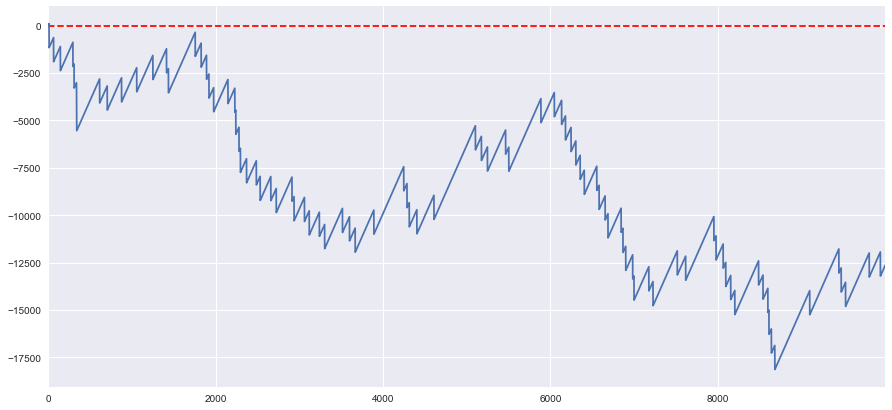

In [13]:
df2['profit_path'] = df2.returns.cumsum() #calculate the profit path

#chart the profit path
plt.figure(figsize=(15, 7)) #chart size
plt.axhline(y=0, color='red', linestyle='--') #add zero line
df2['profit_path'].plot() #line chart

The chart above is just one simlulation. We can run several of these simulations to get a sense of the distribution of paths. Below I have run 100 simulations of playing the martingale stratefy 1,000 times in a row. What is clear from the chart is that this strategy is a loser!

In [14]:
runs = 100
run_len = 10000
lim = 1000

In [15]:
for j in range(0,runs):
    if j==0:
        sim_games3 = [simulate_strategy_with_limit(lim) for i in range(run_len)]
        df3 = pd.DataFrame(sim_games3) #load into df
        df3 = df3.rename(index=str, columns={0: "turns", 1: "last_bet", 2: "cumul_bet", 3: "returns"}) #label columns
        df3[j] = df3.returns.cumsum()
    else:
        sim_games4 = [simulate_strategy_with_limit(lim) for i in range(run_len)]
        df4 = pd.DataFrame(sim_games4) #load into df
        df4 = df4.rename(index=str, columns={0: "turns", 1: "last_bet", 2: "cumul_bet", 3: "returns"}) #label columns
        df3[j] = df4.returns.cumsum()

#clear out column
df3 = df3.drop(["turns", "last_bet","cumul_bet","returns"], axis=1)

/Users/macduff/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


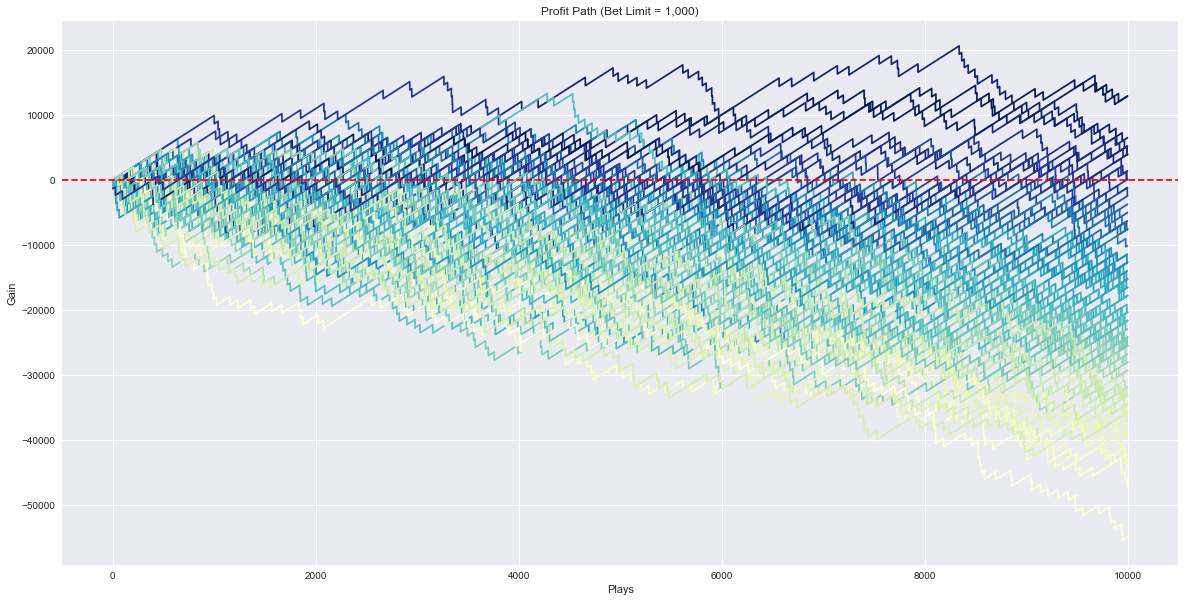

In [16]:
#CHART
data=df3
fig1 = plt.figure(figsize=(20, 10))
ax1 = fig1.add_subplot(1,1,1)

#plots
for i in range(0,len(data.columns)):
    ax1.plot(data[[i]])

#colour map
colormap = plt.cm.YlGnBu

#create a mapping of subplot number to color
vals = df3.transpose().groupby('9999').size().index #final states
colors_temp = [colormap(i) for i in np.linspace(0, 1,len(vals))] # num of colors = num of final states
clabel = df3.transpose()
def label_colors (row):
    for i in range(0,len(vals)):
        if row['9999'] == vals[i]:
            return i
ctemp = clabel.apply (lambda row: label_colors (row),axis=1) #need to map colors to column names
colors = [colors_temp[i] for i in ctemp]

for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

#labels etc
ax1.legend(loc=1)
ax1.set_title('Profit Path (Bet Limit = '+str(lim)+')')
ax1.set_xlabel("Plays")
ax1.set_ylabel("Gain")
plt.axhline(y=0, color='red', linestyle='--')

#plot
plt.show()

If you are more risk averse, and set a lower bet size limit, the strategy is even worse. Below is the same simulation with a £100 bet size limit.

In [17]:
runs = 100
run_len = 10000
lim = 100

In [18]:
for j in range(0,runs):
    if j==0:
        sim_games3 = [simulate_strategy_with_limit(lim) for i in range(run_len)]
        df3 = pd.DataFrame(sim_games3) #load into df
        df3 = df3.rename(index=str, columns={0: "turns", 1: "last_bet", 2: "cumul_bet", 3: "returns"}) #label columns
        df3[j] = df3.returns.cumsum()
    else:
        sim_games4 = [simulate_strategy_with_limit(lim) for i in range(run_len)]
        df4 = pd.DataFrame(sim_games4) #load into df
        df4 = df4.rename(index=str, columns={0: "turns", 1: "last_bet", 2: "cumul_bet", 3: "returns"}) #label columns
        df3[j] = df4.returns.cumsum()

#clear out column
df3 = df3.drop(["turns", "last_bet","cumul_bet","returns"], axis=1)

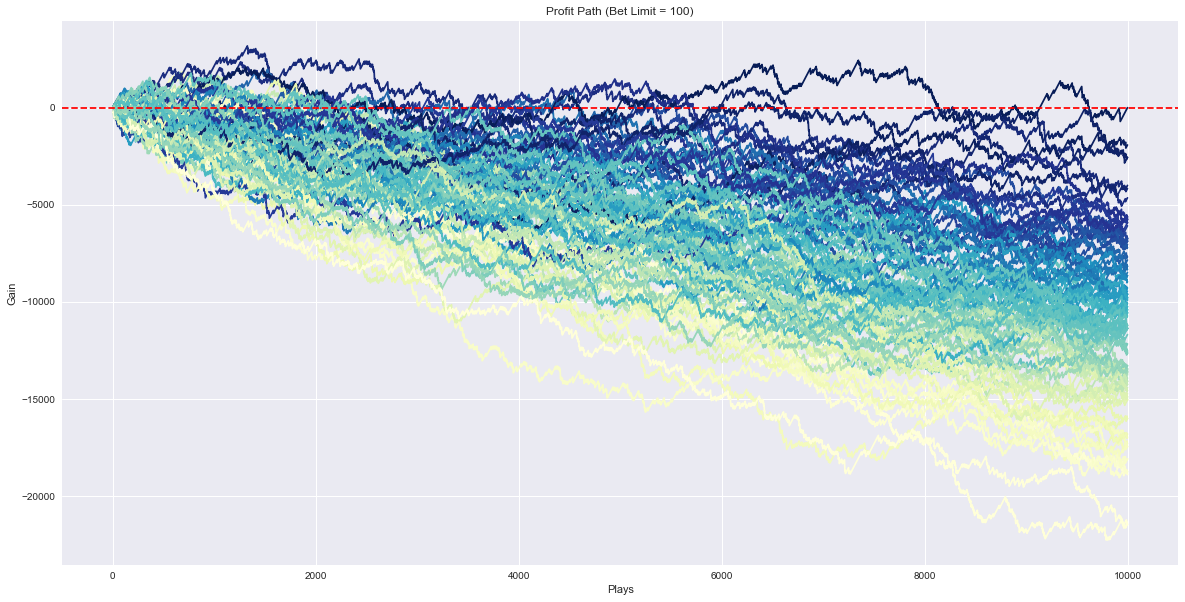

In [21]:
#CHART
data=df3
fig1 = plt.figure(figsize=(20, 10))
ax1 = fig1.add_subplot(1,1,1)

#plots
for i in range(0,len(data.columns)):
    ax1.plot(data[[i]])

#colour map
colormap = plt.cm.YlGnBu

#create a mapping of subplot number to color
vals = df3.transpose().groupby(str(run_len-1)).size().index #final states
colors_temp = [colormap(i) for i in np.linspace(0, 1,len(vals))] # num of colors = num of final states
clabel = df3.transpose()
def label_colors (row):
    for i in range(0,len(vals)):
        if row[str(run_len-1)] == vals[i]:
            return i
ctemp = clabel.apply (lambda row: label_colors (row),axis=1) #need to map colors to column names
colors = [colors_temp[i] for i in ctemp]

for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

#labels etc
ax1.legend(loc=1)
ax1.set_title('Profit Path (Bet Limit = '+str(lim)+')')
ax1.set_xlabel("Plays")
ax1.set_ylabel("Gain")
plt.axhline(y=0, color='red', linestyle='--')

#plot
plt.show()